# Document Clustering and Topic Modeling

In this project,  I use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

## Contents

<ul>
<li>[Part 1: Load Data](#Part-1:-Load-Data)
<li>[Part 2: Tokenizing and Stemming](#Part-2:-Tokenizing-and-Stemming)
<li>[Part 3: TF-IDF](#Part-3:-TF-IDF)
<li>[Part 4: K-means clustering](#Part-4:-K-means-clustering)
<li>[Part 5: Topic Modeling - Latent Dirichlet Allocation](#Part-5:-Topic-Modeling---Latent-Dirichlet-Allocation)
</ul>

# Part 1: Load Data

In [1]:
import seaborn

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import re
import os

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import lda

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chenxijia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Read data from files. In summary, we have 100 titles and 100 synoposes (combined from imdb and wiki).

In [3]:
#import three lists: titles and wikipedia synopses
titles = open('./data/title_list.txt').read().split('\n')
titles = titles[:100] #ensures that only the first 100 are read in

#The wiki synopses and imdb synopses of each movie is seperated by the keywords "BREAKS HERE". 
#Each synoposes may consist of multiple paragraphs.
synopses_wiki = open('./data/synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_imdb = open('./data/synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

#Combine imdb and wiki to get full synoposes for the top 100 movies. 
synopses = []
for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)
    
#Because these synopses have already been ordered in popularity order, 
#we just need to generate a list of ordered numbers for future usage.
ranks = range(len(titles))

# Part 2: Tokenizing and Stemming

Load stopwords and stemmer function from NLTK library.
Stop words are words like "a", "the", or "in" which don't convey significant meaning.
Stemming is the process of breaking a word down into its root.

In [4]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

print "We use " + str(len(stopwords)) + " stop-words from nltk library."
print stopwords[:10]

We use 179 stop-words from nltk library.
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u"you're"]


In [5]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

#sent_tokenize: split text into sentences
#word_tokenize: split sentences into words
def tokenization_and_stemming(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
#     tokens=[]
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if word not in stopwords:
#                 tokens.append(word);   
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]#stemmer.stem() used to pick up cigen(stem) in words
    return stems

def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [6]:
nltk.download('punkt')
tokenization_and_stemming("she looked at her father's arm.")

[nltk_data] Downloading package punkt to /Users/chenxijia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[u'look', u'father', "'s", u'arm']

Use our defined functions to analyze (i.e. tokenize, stem) our synoposes.

In [7]:
#build up a stem list(docs_stemmed) and a complete word list(docs_tokenized)
docs_stemmed = []
docs_tokenized = []
for i in synopses:
    tokenized_and_stemmed_results = tokenization_and_stemming(i)
    docs_stemmed.extend(tokenized_and_stemmed_results)
    
    tokenized_results = tokenization(i)
    docs_tokenized.extend(tokenized_results)

Create a mapping from stemmed words to original tokenized words for result interpretation.

In [8]:
#make up a dictionary indicate the complete form of a stem
vocab_frame_dict = {docs_stemmed[x]:docs_tokenized[x] for x in range(len(docs_stemmed))}
print vocab_frame_dict['angel']

angeles


# Part 3: TF-IDF

In [13]:
#define vectorizer parameters
#max_df(a word appears 8 times in 10 article, then delete it/also, @param min_df->less than 20 percent also delete it)
#ngram_range(1,1 only consider single word, 1,2 consider single word and word combination(contains 2 continueous words))
#tokenizer(the tokenize and stem model)

tfidf_model = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(synopses) #fit the vectorizer to synopses

print "In total, there are " + str(tfidf_matrix.shape[0]) + \
      " synoposes and " + str(tfidf_matrix.shape[1]) + " terms."

In total, there are 100 synoposes and 538 terms.


In [16]:
print tfidf_matrix[0]

  (0, 134)	0.047326762822265396
  (0, 133)	0.10014225622178521
  (0, 231)	0.0406338952993463
  (0, 405)	0.11417147602852429
  (0, 327)	0.07546593975046426
  (0, 536)	0.05900743243383316
  (0, 124)	0.06524084344487102
  (0, 192)	0.5521782660510217
  (0, 455)	0.2395788878566075
  (0, 262)	0.04569219786306756
  (0, 234)	0.045569859238455655
  (0, 426)	0.04645251282033316
  (0, 319)	0.04425557432537487
  (0, 230)	0.11300130397893356
  (0, 317)	0.03421496445764258
  (0, 57)	0.08715061982923508
  (0, 434)	0.04755874823027948
  (0, 439)	0.02457503722508389
  (0, 39)	0.0709901442333981
  (0, 167)	0.030461465242045037
  (0, 373)	0.11417147602852429
  (0, 429)	0.038852562711093365
  (0, 390)	0.07667116833622664
  (0, 449)	0.04569219786306756
  (0, 44)	0.07447840347702878
  :	:
  (0, 61)	0.014986860327103705
  (0, 11)	0.013690156630016555
  (0, 26)	0.014986860327103705
  (0, 314)	0.013309938214255971
  (0, 184)	0.015230732621022518
  (0, 410)	0.009827024310920572
  (0, 388)	0.015230732621022518
 

In [10]:
tfidf_model.get_params()

{'analyzer': u'word',
 'binary': False,
 'decode_error': u'strict',
 'dtype': numpy.int64,
 'encoding': u'utf-8',
 'input': u'content',
 'lowercase': True,
 'max_df': 0.8,
 'max_features': 200000,
 'min_df': 0.2,
 'ngram_range': (1, 1),
 'norm': u'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': 'english',
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': u'(?u)\\b\\w\\w+\\b',
 'tokenizer': <function __main__.tokenization_and_stemming>,
 'use_idf': True,
 'vocabulary': None}

Save the terms identified by TF-IDF.

In [19]:
tf_selected_words = tfidf_model.get_feature_names()

In [20]:
tf_selected_words

[u"'d",
 u'abandon',
 u'abl',
 u'accept',
 u'accid',
 u'accompani',
 u'accus',
 u'act',
 u'action',
 u'actual',
 u'admit',
 u'afterward',
 u'ago',
 u'agre',
 u'air',
 u'aliv',
 u'allow',
 u'alon',
 u'alreadi',
 u'alway',
 u'american',
 u'angri',
 u'angrili',
 u'announc',
 u'anoth',
 u'answer',
 u'anyon',
 u'anyth',
 u'apart',
 u'appar',
 u'appear',
 u'approach',
 u'area',
 u'argu',
 u'arm',
 u'armi',
 u'arrang',
 u'arrest',
 u'arriv',
 u'ask',
 u'assign',
 u'assist',
 u'assum',
 u'attack',
 u'attempt',
 u'attend',
 u'attent',
 u'attract',
 u'audienc',
 u'avoid',
 u'away',
 u'bad',
 u'bar',
 u'bare',
 u'battl',
 u'beat',
 u'becom',
 u'bed',
 u'beg',
 u'believ',
 u'best',
 u'better',
 u'big',
 u'black',
 u'blow',
 u'board',
 u'bodi',
 u'book',
 u'boss',
 u'boy',
 u'break',
 u'brief',
 u'bring',
 u'broken',
 u'brother',
 u'build',
 u'burn',
 u'busi',
 u'buy',
 u'ca',
 u'camp',
 u'captain',
 u'captur',
 u'car',
 u'care',
 u'career',
 u'carri',
 u'case',
 u'catch',
 u'caus',
 u'chanc',
 u'c

In [21]:
#there are 100 subarray in this array, each indicates a synposes
#and in each subarray, there are 538 numbers indicating that every single word's weight in this article(synposes)
# To sum up, every synposes is indicated by a vector(total 100 vectors) built from 538 words
tfidf_matrix.toarray()

array([[0.01548417, 0.        , 0.        , ..., 0.08116415, 0.05900743,
        0.0406339 ],
       [0.05836682, 0.        , 0.0244088 , ..., 0.05948916, 0.        ,
        0.00957297],
       [0.        , 0.        , 0.01960667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01356779, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01780244],
       [0.01434229, 0.0296827 , 0.03598737, ..., 0.00835319, 0.02732796,
        0.01881867],
       [0.20623577, 0.        , 0.        , ..., 0.06005757, 0.        ,
        0.06765104]])

# (Optional) Calculate Document Similarity

In [22]:
#cos value between two vector -> how are they similar with each other
#ex. select first vector, if it and another vector's cos >1/2, they are assigned to same class.
#Overall, this matrix is a 100*100 matrix, each element indicated how similar are two vector.
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)
print cos_matrix

[[1.         0.1996283  0.23342595 ... 0.3581728  0.3277855  0.17714484]
 [0.1996283  1.         0.26626879 ... 0.26910321 0.22856581 0.10870124]
 [0.23342595 0.26626879 1.         ... 0.27738654 0.24669308 0.12805055]
 ...
 [0.3581728  0.26910321 0.27738654 ... 1.         0.55040973 0.08151334]
 [0.3277855  0.22856581 0.24669308 ... 0.55040973 1.         0.13005234]
 [0.17714484 0.10870124 0.12805055 ... 0.08151334 0.13005234 1.        ]]


In [23]:
len(cos_matrix[99])

100

# Part 4: K-means clustering

In [24]:
from sklearn.cluster import KMeans

num_clusters = 5
km = KMeans(n_clusters=num_clusters)#default params are in document's 4.2
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

## 4.1. Analyze K-means Result

In [25]:
# create DataFrame films from all of the input files.
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster'])

In [26]:
frame.head(10)

,rank,title,cluster
1,0,The Godfather,1
2,1,The Shawshank Redemption,2
2,2,Schindler's List,2
3,3,Raging Bull,3
2,4,Casablanca,2
2,5,One Flew Over the Cuckoo's Nest,2
1,6,Gone with the Wind,1
3,7,Citizen Kane,3
3,8,The Wizard of Oz,3
2,9,Titanic,2


In [27]:
print "Number of films included in each cluster:"
frame['cluster'].value_counts().to_frame()

Number of films included in each cluster:


,cluster
4,32
1,23
2,21
3,18
0,6


In [28]:
grouped = frame['rank'].groupby(frame['cluster'])
print "Average rank (1 to 100) per cluster:"
grouped.mean().to_frame()

Average rank (1 to 100) per cluster:


,rank
cluster,
0,52.833333
1,51.130435
2,35.047619
3,41.444444
4,61.718750


In [29]:
km.cluster_centers_.argsort()

array([[131, 232, 389, ..., 192, 302, 213],
       [206, 354, 249, ..., 511, 194, 192],
       [343, 121,  68, ..., 106,  35, 452],
       [ 81, 108, 250, ..., 327, 210, 194],
       [431, 372, 373, ..., 271,  83, 359]])

In [31]:
#important!!! for each group/class of movies, pick up the key words in their symposes, then we can know which 
#kind of movie they are

#km.cluster_centers_ means pick up the center point in each clusters, it is a 5*538 matrix
#argsort():  means sort value in a increasing order, but the ouput value for each item is their index
#[:,::-1] means: 1st param is the whole array, 2nd param is decreasing order

print "<Document clustering result by K-means>"

#km.cluster_centers_ denotes the importances of each stems in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print "Cluster " + str(i) + " words:" ,
    Cluster_keywords_summary[i] = []
    
#order_centroids[i, :6]: for each cluster, pick up the 6 most important stems's index
#vocab_frame_dict[tf_selected_words[ind]] : find the coresponding stem according to index, and find stem's complete
#word in dictionary

    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(vocab_frame_dict[tf_selected_words[ind]])
        print vocab_frame_dict[tf_selected_words[ind]] + ",",
    print
    #Here ix means index, which is the clusterID of each item. Pick up the row=i, column='title' movie in frame and 
    #then build up a list
    #Without tolist, the values result from dataframe is <type 'numpy.ndarray'>
    cluster_movies = frame.ix[i]['title'].values.tolist()
    print "Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): " 
    print ", ".join(cluster_movies)
    print

<Document clustering result by K-means>
Cluster 0 words: george, marries, family, woman, friend, john,
Cluster 0 titles (6 movies): 
It's a Wonderful Life, The Philadelphia Story, An American in Paris, The King's Speech, A Place in the Sun, Tootsie

Cluster 1 words: family, father, war, son, marries, love,
Cluster 1 titles (23 movies): 
The Godfather, Gone with the Wind, The Godfather: Part II, Forrest Gump, The Sound of Music, Amadeus, Gladiator, A Streetcar Named Desire, The Best Years of Our Lives, Ben-Hur, Doctor Zhivago, Braveheart, The Pianist, Goodfellas, City Lights, It Happened One Night, Out of Africa, Terms of Endearment, Giant, The Grapes of Wrath, Wuthering Heights, Rebel Without a Cause, Yankee Doodle Dandy

Cluster 2 words: soldiers, army, commanded, orders, war, killing,
Cluster 2 titles (21 movies): 
The Shawshank Redemption, Schindler's List, Casablanca, One Flew Over the Cuckoo's Nest, Titanic, Lawrence of Arabia, Star Wars, The Bridge on the River Kwai, Dr. Strangel

In [33]:
order_centroids

array([[213, 302, 192, ..., 389, 232, 131],
       [192, 194, 511, ..., 249, 354, 206],
       [452,  35, 106, ...,  68, 121, 343],
       [194, 210, 327, ..., 250, 108,  81],
       [359,  83, 271, ..., 373, 372, 431]])

## 4.2. Plot K-means Result

In [34]:
tfidf_matrix.toarray()

array([[0.01548417, 0.        , 0.        , ..., 0.08116415, 0.05900743,
        0.0406339 ],
       [0.05836682, 0.        , 0.0244088 , ..., 0.05948916, 0.        ,
        0.00957297],
       [0.        , 0.        , 0.01960667, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01356779, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01780244],
       [0.01434229, 0.0296827 , 0.03598737, ..., 0.00835319, 0.02732796,
        0.01881867],
       [0.20623577, 0.        , 0.        , ..., 0.06005757, 0.        ,
        0.06765104]])

In [37]:
#for the purpose of drawing, using pca to reduce 538 features to 2 features

pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

#now X is a new 100*2 matrix, 100 movies with only two features
#X[:, 0] 1st param means for the total rows, 2nd param means for these rows pick up the first element
xs, ys = X[:, 0], X[:, 1]

#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

In [38]:
xs

array([-0.01626843,  0.02988208,  0.27364784, -0.07972765,  0.10396401,
        0.03821519,  0.06221408, -0.15643847, -0.00240211, -0.03064285,
        0.37671207, -0.10572531, -0.23324864, -0.21538112, -0.19663029,
       -0.06520501, -0.05978386,  0.05558293, -0.09796881,  0.22442077,
       -0.0961553 ,  0.02839821, -0.03027819, -0.04583647,  0.37412891,
       -0.17864517, -0.12779829, -0.15088857, -0.09007835,  0.4660598 ,
       -0.12340045,  0.41256987, -0.06447761,  0.26749208,  0.32382401,
        0.23365626,  0.42699459,  0.09302201,  0.28295758, -0.14830871,
       -0.10460035, -0.1200011 , -0.07760177, -0.17959741, -0.00466456,
       -0.1164564 ,  0.01905854,  0.09193232,  0.47550293,  0.12775433,
        0.19031061, -0.02816287,  0.13344325,  0.19559428, -0.18215326,
        0.50845196,  0.03846582,  0.37893974,  0.13467435, -0.08278944,
       -0.17085756,  0.18160239,  0.37462079, -0.17344876, -0.08131232,
       -0.06791766, -0.26988275, -0.13404752, -0.22473664,  0.00

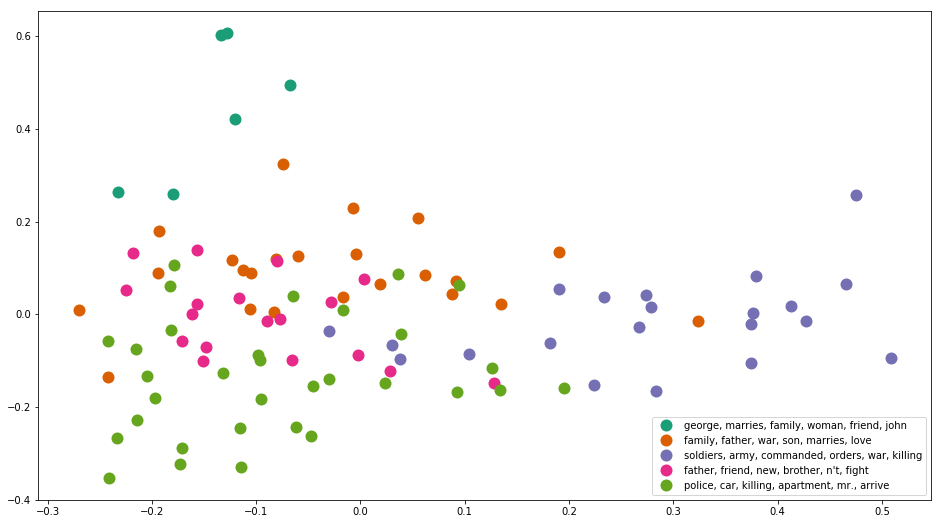

In [39]:
%matplotlib inline 

#create data frame with PCA cluster results
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 
groups = df.groupby(clusters)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

plt.show() #show the plot

In [40]:
ax

In [41]:
plt.close()

# Part 5: Topic Modeling - Latent Dirichlet Allocation

In [42]:
#Now we use synopses to build a 100*538 matrix (terms)
#Build up a 100*538 matrix, each element means each stem's appearance times in each synopses

#terms_dict: used to find the index of each 538 words
terms_dict = {tf_selected_words[x]:x for x in range(len(tf_selected_words))}

feature_matrix_synopses_tf = []
for i in synopses:
    current_doc_stats = [0] * len(tf_selected_words)
    allwords_stemmed = tokenization_and_stemming(i)
    for get_terms in allwords_stemmed:
        if get_terms in tf_selected_words:
            current_doc_stats[terms_dict[get_terms]] += 1
    current_doc_stats = np.asarray(current_doc_stats)
    feature_matrix_synopses_tf.append(current_doc_stats)
    
feature_matrix_synopses_tf = np.asarray(feature_matrix_synopses_tf)

In [43]:
feature_matrix_synopses_tf

array([[1, 0, 0, ..., 9, 4, 4],
       [4, 0, 2, ..., 7, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 2],
       [1, 2, 3, ..., 1, 2, 2],
       [4, 0, 0, ..., 2, 0, 2]])

In [44]:
a = [[1.0],[2.0]]
int (a[0][0])

1

In [45]:
tfidf_array=tfidf_matrix.toarray()
for i in range(len(tfidf_array)):
    for j in range(len(tfidf_array[i])):
        tfidf_array[i][j] = tfidf_array[i][j]*1000
        tfidf_array[i][j] = int(tfidf_array[i][j])
        
#use this to change matrix into an int array
tfidf_array = tfidf_array.astype(int)

In [46]:
print tfidf_array

[[ 15   0   0 ...  81  59  40]
 [ 58   0  24 ...  59   0   9]
 [  0   0  19 ...   0   0   0]
 ...
 [ 13   0   0 ...   0   0  17]
 [ 14  29  35 ...   8  27  18]
 [206   0   0 ...  60   0  67]]


In [47]:
model = lda.LDA(n_topics=5, n_iter=500, random_state=1)

In [48]:
a = np.array([1,2,3,4,5])[np.array([0,3])]

In [49]:
a

array([1, 4])

<li> "model.topic_word_" saves the importance of tf_selected_words in LDA model, i.e. words similarity matrix
<li> The shape of "model.topic_word_" is (n_topics,num_of_selected_words)
<li> "model.doc_topic_" saves the document topic results, i.e. document topic matrix.
<li> The shape of "model.doc_topic_" is (num_of_documents, n_topics)

In [53]:
#the lda model only accept int data but not float data
#Considering topic_word_ and doc_topic_, read details in LaiData Documentation 5.2 in Unsupervisedlearning II
#Remember: documentation->topic->words , each process pick up the n highest element 

model.fit(tfidf_array)
topic_word = model.topic_word_  # model.components_ also works, topic_word is a topic*stem matix, 
# the number is the point estimate of the topic-word distributions (Phi in literature)
n_top_words = 7

topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):#enumerate(): used to generate a combination of element and its index 
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] #see details implementation in 
    #last In[]
    #[:-n_top_words:-1]: means pick up 6 most important stems
    for j in range(len(lda_topic_words)):
        lda_topic_words[j] = vocab_frame_dict[lda_topic_words[j]]
    topic_keywords_list.append(lda_topic_words.tolist())#Remember!!! np.array.tolist() 

INFO:lda:n_documents: 100
INFO:lda:vocab_size: 538
INFO:lda:n_words: 968593
INFO:lda:n_topics: 5
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -7551008
INFO:lda:<10> log likelihood: -6806900
INFO:lda:<20> log likelihood: -6493375
INFO:lda:<30> log likelihood: -6441773
INFO:lda:<40> log likelihood: -6419736
INFO:lda:<50> log likelihood: -6411471
INFO:lda:<60> log likelihood: -6405168
INFO:lda:<70> log likelihood: -6400461
INFO:lda:<80> log likelihood: -6398900
INFO:lda:<90> log likelihood: -6396208
INFO:lda:<100> log likelihood: -6391927
INFO:lda:<110> log likelihood: -6391196
INFO:lda:<120> log likelihood: -6389115
INFO:lda:<130> log likelihood: -6388653
INFO:lda:<140> log likelihood: -6388522
INFO:lda:<150> log likelihood: -6387772
INFO:lda:<160> log likelihood: -6388565
INFO:lda:<170> log likelihood: -6389609
INFO:lda:<180> log likelihood: -6388279
INFO:lda:<190> log likelihood: -6387139
INFO:lda:<200> log likelihood: -6384448
INFO:lda:<210> log likelihood: -6385932
INFO:lda:<220

In [55]:
topic_word

array([[9.23151952e-04, 1.13378994e-03, 6.19523490e-08, ...,
        1.86482766e-03, 7.06318731e-04, 2.16219893e-03],
       [5.16389212e-08, 2.98478129e-03, 8.77913300e-04, ...,
        5.16389212e-08, 5.16389212e-08, 1.92101951e-03],
       [1.94906244e-03, 5.63296565e-08, 1.45336147e-03, ...,
        7.92000603e-03, 5.98226585e-03, 4.35433877e-03],
       [2.03145906e-03, 4.12889792e-08, 2.46086445e-03, ...,
        4.00920117e-03, 4.12889792e-08, 2.57647359e-03],
       [5.15912336e-08, 2.65700012e-03, 9.18375549e-04, ...,
        1.03187626e-03, 9.20908678e-03, 2.06370093e-03]])

In [56]:
# np.argsort(topic_dist)

In [57]:
# list(enumerate(topic_word))

In [58]:
#doc_topic is the doc*topic matrix
doc_topic = model.doc_topic_
topic_doc_dict = {}

print "<Document clustering result by LDA>"
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()#argmax() is the index of max value
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [titles[i]]
    else:
        topic_doc_dict[topicID].append(titles[i])
for i in topic_doc_dict:
    print "Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i])
    print "Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): " 
    print ', '.join(topic_doc_dict[i])
    print

<Document clustering result by LDA>
Cluster 0 words: water, ship, captain, escape, prison, mother
Cluster 0 titles (13 movies): 
The Shawshank Redemption, The Wizard of Oz, Titanic, The Sound of Music, Star Wars, The Silence of the Lambs, Chinatown, The Lord of the Rings: The Return of the King, Raiders of the Lost Ark, Ben-Hur, Close Encounters of the Third Kind, Stagecoach, Mutiny on the Bounty

Cluster 1 words: army, killing, soldiers, war, men, general
Cluster 1 titles (23 movies): 
Schindler's List, Casablanca, Lawrence of Arabia, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, Gladiator, From Here to Eternity, Saving Private Ryan, Unforgiven, Patton, Braveheart, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, Platoon, High Noon, Dances with Wolves, The Pianist, The Deer Hunter, All Quiet on the Western Front, The Grapes of Wrath, Shane, Network

Cluster 2 words: love, family, singing, marrie

In [59]:
doc_topic

array([[1.95305433e-02, 2.19311527e-01, 1.72080179e-01, 1.22753892e-01,
        4.66323858e-01],
       [4.29297258e-01, 1.03268446e-05, 7.88041514e-02, 3.64444674e-01,
        1.27443590e-01],
       [1.99884075e-01, 5.06119886e-01, 1.19219437e-01, 1.11008066e-01,
        6.37685360e-02],
       [1.11055583e-05, 1.13287801e-01, 1.01515909e-01, 4.41457049e-01,
        3.43728136e-01],
       [1.41304019e-01, 2.94599365e-01, 1.96066764e-01, 1.27285563e-01,
        2.40744289e-01],
       [2.31527001e-01, 1.72402124e-01, 5.73483104e-02, 5.38713164e-01,
        9.39982140e-06],
       [1.32860932e-01, 2.65278535e-01, 3.68334605e-01, 1.95581235e-01,
        3.79446928e-02],
       [6.53907788e-02, 9.15708988e-06, 5.04839522e-01, 2.86900783e-01,
        1.42859759e-01],
       [5.61874257e-01, 1.03321796e-05, 1.37015033e-01, 3.01090045e-01,
        1.03321796e-05],
       [9.99950406e-01, 1.23984874e-05, 1.23984874e-05, 1.23984874e-05,
        1.23984874e-05],
       [3.00822574e-01, 6.5000

In [53]:
doc_topic[0]

array([0.01953054, 0.21931153, 0.17208018, 0.12275389, 0.46632386])

# Appendix: K-means

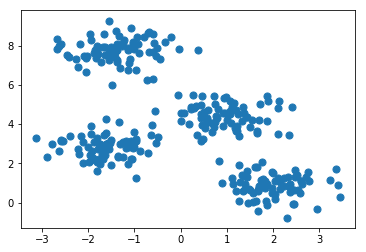

In [54]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], s=50);

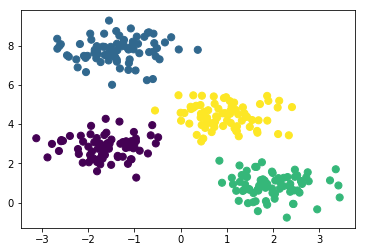

In [55]:
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50);